# 21M.387 Fundamentals of Music Processing
## Problem Set 6: Chord Recognition

Make sure all your answers and plots display when the code block is run. You can leave word-based answers in code comments or markdown cells.

You may use any fmplib functions from __previous__ units in your answers. You may __not__ use any fmplib functions from the current unit in your answers (unless explicitly noted). But you can use the current unit's fmplib for testing your code.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from ipywidgets import interact
import sys
sys.path.append("..")
import fmplib as fmp

plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['image.interpolation'] = 'nearest'

fmp.documentation_button()

## Exercise 1

The data loaded below contains binary chord templates for four chords, arranged as a $4 \times 12$ matrix.

Identify each of the four chords. Visualizing this matrix with `plt.imshow()` can be useful.

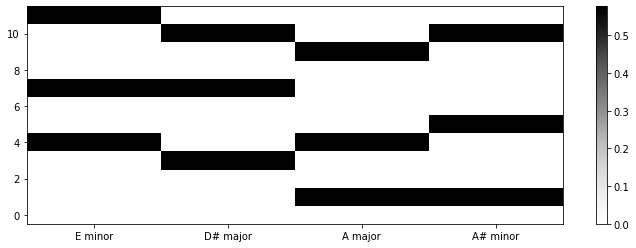

In [24]:
some_chords = np.load('data/ex1.npy')

c_names = ['E minor', 'D# major', 'A major', 'A# minor']
# for i in range(len(c_names)):
#     c = some_chords[i,:]
#     chord = list(np.where(c > 0)[0])
#     name = c_names[i]
#     print(f'{chord} ({name})')

plt.imshow(np.atleast_2d(some_chords).T, origin='lower', aspect='auto', cmap='Greys')
plt.xticks(np.arange(some_chords.shape[0]), ['E minor', 'D# major', 'A major', 'A# minor'])
plt.colorbar()
plt.show()

## Exercise 2

In the following example, a simple template-based chord classifier is estimating chords in Bach's first prelude of the _Well-Tempered-Clavier_. The colored labels are as follows:
- TP: True Positive - the algorithm picked the correct chord
- FN: False Negative - shows the chord that should have been picked, but wasn't
- FP: False Positive - shows the incorrect chord that the algorithm picked 

<img src="images/bach_evaluation.png" width=700>

The algorithm is doing a good job in bars 1 and 4, but making more mistakes in bars 2 and 3. Why is this the case?

Answer:



## Exercise 3

Write the function `make_triads_templates()` to produce $\mathcal{T}_h$, a harmonics chords template matrix with 24 rows where each row is a chord template:
- rows $[0-11]$ are the major triads (starting with __C__)
- rows $[12-23]$ are the minor triads (starting with __Cm__)

Inputs: 
- `alpha`: $\alpha$, the harmonic decay value for creating harmonic templates.

Output:
- $\mathcal{T}_h$, the $24 \times 12$ harmonic chord templates matrix for all major and minor triads

For this exercise, you can use `fmp.harmonics_chord_template()`.

Test your function with $\alpha = 0.6$ and plot the resulting matrix with `plt.imshow()`.

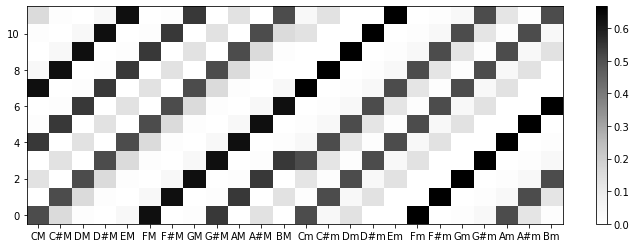

In [15]:
def make_triads_templates(alpha) :
    c_maj = [0, 4, 7]
    c_min = [0, 3, 7]
    maj_triads = np.array([[(i + j) % 12 for j in c_maj] for i in range(12)])
    min_triads = np.array([[(i + j) % 12 for j in c_min] for i in range(12)])
    triads = np.concatenate((maj_triads, min_triads))
    
    ts = np.zeros((24, 12))
    for i, t in enumerate(triads):
        ts[i] = fmp.harmonics_chord_template(t, alpha)
    
    return ts
    
# plot your result:
ts = make_triads_templates(0.6)
plt.imshow(np.atleast_2d(ts).T, origin='lower', aspect='auto', cmap='Greys')
cs = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
plt.xticks(np.arange(ts.shape[0]), [str(c) + 'M' for c in cs] + [str(c) + 'm' for c in cs])
plt.colorbar()
plt.show()

## Exercise 4

Write the function `estimate_chords()` to produce an array of chord estimates given a song's chromagram using the template method described in lecture. 

Inputs:
- `chroma`: $\mathbf{C}$, the chromagram 
- `alpha`: $\alpha$, the parameter for creating the harmonic chord templates $\mathcal{T}_h$

Output:
- $\lambda^{\text{est}}[n]$, a vector of the same length as $\mathbf{C}$, containing index values $[0:24)$ of the most likely chord.

In [ ]:
def estimate_chords(chroma, alpha):
    pass

Estimate the chords of the first 51 seconds of _Here Comes the Sun_ by The Beatles using this function.

- Create a normalized chromagram using $N=4096, H=2048, \gamma=1$ using `fmp.make_chromagram()`.
- Estimate the chords, storing results in `ex4_est`
- Plot the chromagram (in its own figure)
- Plot `ex4_est` with a red dot at each point, using 'ro', in its own figure.

In [ ]:
snd = fmp.load_wav("audio/beatles_here_comes_the_sun.wav",0, 51)
fs = 22050
ipd.Audio(snd, rate=fs)

ex4_est = ...

# plots...

## Exercise 5

Write `calc_chord_score()`, a function to calculate the score for the estimated chords compared to the ground-truth reference annotated chords, as described in Lecture.

Inputs:
- `est`: $\lambda^{\text{est}}[n]$, the algorithmically generated chord estimate vector
- `ref`: $\lambda^{\text{ref}}[n]$, the ground truth reference vector

Output:
- a score value in the range $[0,1]$


Assume that $\lambda^{\text{est}}[n]$ and $\lambda^{\text{ref}}[n]$ are sampled at the same rate $F_f$. However, it is possible that they are not the same length.

The score is based on the common (overlapping) region between the two vectors, and also where  $\lambda^{\text{ref}}[n] \ne -1$. That is, ignore regions where no reference chord is annotated in calculating the score.


In [ ]:
def calc_chord_score(est, ref):
    pass

Now calculate the score of the estimated chord of Exercise 4 using the reference annotations `"audio/beatles_here_comes_the_sun.lab"`, which you can load with `fmp.load_chord_annotations()`.

Call this score `ex5_score`.

In [ ]:
ex5_ref = ...
ex5_score = ...

## Exercise 6

This score is quite poor. One reason is that The Beatles played this song with a tuning that is different from $A4=440$.

There is an optional parameter in `fmp.make_chromagram()` for providing a tuning value. This is normally 0, but can be used to adjust the tuning of the chromagram by fractional semitones. For example, passing in the argument `tuning = -0.2` will create a chromagram that works well for instruments playing 20 cents flat from $A4=440$. (Remember that 100 cents = 1 semitone).

Write the function `calc_chord_score_with_tuning()` that returns a score value, similarly to _Exercise 5_, but with a "tuned chromagram" (using the same parameters for $N, H, \gamma$). If you pass in a tuning value of 0, you should get same score as above.

Inputs:
- `snd`: the wave data
- `ref`: $\lambda^{\text{ref}}[n]$, the ground truth reference vector
- `tuning`: the tuning parameter for creating the chromagram, with values in the range $[-0.5, +0.5]$ representing a tuning of -50 cents to +50 cents.

Output:
- the score of the chord estimation

In [ ]:
def calc_chord_score_with_tuning(snd, ref, tuning):
    pass

Now try a bunch tuning values in the range $[-0.5, +0.5]$ and see what tuning value produces the best chord score. This value is the most likely tuning used in the original recording.

Write the function `find_best_tuning()` that returns the best tuning estimate.

Inputs:
- `snd`: the wave data
- `fs`: $F_s$, the sampling rate of `snd`
- `fft_size`, `hop_size`, `gamma`: parameters for creating the chromagram
- `alpha`: $\alpha$, the harmonic decay value for creating harmonic templates.
- `ref`: $\lambda^{\text{ref}}[n]$, the ground truth reference vector

Output:
- the tuning parameter which maximizes the score of `calc_chord_score_with_tuning()`.

In [ ]:
def find_best_tuning(snd, fs, fft_size, hop_size, gamma, alpha, ref):
    tunings = np.linspace(-0.5, 0.5, 51)
    # complete this function


Using the same parameters for $N$, $H$, $\gamma$, and $\alpha$ as above, calculate and print the best tuning value (storing in `ex6_tuning`). Then, create:
- `ex6_chroma`, the properly tuned chromagram
- `ex6_est`, the estimated chords for this chromagram
- `ex6_score`, the score for these estimated chords

As above, plot `ex6_chroma` and `ex6_est`

In [ ]:
ex6_tuning = ...
ex6_chroma = ...
ex6_est = ...
ex6_score = ...

# plots...

## Exercise 7

We have seen examples of temporal smoothing (CENS chromagrams). Here you will create a function that applies temporal smoothing to all the rows of a matrix (like a chromagram).

Write the function `temporal_smoothing()` that applies a simple low-pass filter across each row of the input matrix.

Inputs:
- `mtx`: The input matrix
- `win_len`: $L$, the length of a rectangular window used to smooth the matrix

Output:
- A smoothed matrix of the same dimensions as `mtx`

For each row vector $x$ of the input matrix, create a smoothed version, $x^L$ by using `np.convolve()` to convolve $x$ with a rectangular window of length $L$ and amplitude $1/L$. It is the equivalent of performing the operation:

$$ x^L[n] = {1 \over L} \sum_{l=-L/2}^{L - L/2 - 1}x[n+l] $$

In other words, $x^L[n]$ just becomes the average value of its neighbors. To keep $x^L$ the same size as $x$, use the optional argument `mode='same'`.

In [ ]:
def temporal_smoothing(mtx, win_len):
    pass


Using `temporal_smoothing()`, write the function `find_best_smoothing_length()` that finds the best window length $L$ to maximize the chords estimation score by testing against different filtered chromagrams.

Inputs:
- `chroma`: $\mathbf{C}$, the chromagram
- `alpha`: $\alpha$, the harmonic decay value for creating harmonic templates
- `ref`: $\lambda^{\text{ref}}[n]$, the ground truth reference vector

Output:
- the optimal length $L$ which maximizes `calc_chord_score()` when filtering $\mathbf{C}$ with different lengths.

In [ ]:
def find_best_smoothing_length(chroma, alpha, ref):
    win_lengths = np.arange(1, 101, 2) # odd values preferred
    # complete this function


Using the a properly tuned chromagram of _Here Comes the Sun_ from _Exercise 6_, calculate and print the best window length value (storing in `ex7_win_len`). Then, create:

- `ex7_chroma`, the smoothed chromagram using the optimal $L$
- `ex7_est`, the estimated chords for this chromagram
- `ex7_score`, the score for these estimated chords

As above, plot `ex7_chroma` and `ex7_est`

In [ ]:
ex7_win_len = ...
ex7_chroma = ...
ex7_est = ...
ex7_score = ...

# plots...

## Exercise 8

Write the function `generate_markov_sequence` to generate a random sequence of states.

Inputs:
- `init_p`: initial probabilities (vector $C$)
- `trans_p`: transition probs (matrix $A$)
- `length`: length of sequence to generate    

Output:
- an `np.array` (of type `int`) representing the state 

Strategy:

- First generate the initial state (based on $C$).  
- Then generate the rest of the states in a loop (based on $A$)

I recommend looking at the function `np.random.choice` and looking closely at the optional input parameter `p`.

In [ ]:
def generate_markov_sequence(init_p, trans_p, length):
    pass

Generate a sequence of length 30 with the Markov parameters below.

Run this generating code multiple times. What do you notice about the sequences generated? Why does this happen?

In [ ]:
C = np.array((.8, .2, 0))
A = np.array(((.8, .2, 0), (.1, .8, .1), (0, 0, 1.)))


## Exercise 9

There are three probability sets that need to be defined for an HMM model:
- $A$, the transition probabilities matrix for the hidden states
- $C$, the initial probabilities vector for the hidden states
- $B$, the emissions probabilities matrix that relate hidden states to observations

In this exercise, you will create these probability sets for the 24-chord model we have been using (12 major, 12 minor). Remember that probabilities must sum to one.

Write the function `make_trans_prob_matrix()` to create $A$. $A$ should have a large value on the diagonal (ie, self-transition probabilities) and small value everywhere else.

Inputs:
- `diag_ratio`: the diagonal-to-non-diagonal value (for example `diag_ratio=4` would have the diagonal values be 4x the other values).

Returns:
- $A$, the probability matrix.

Create and plot this matrix for a diagonal ratio of 3 (set as `trans_prob`). Use `plt.colorbar()` so you can graphically inspect the values.

In [ ]:
def make_trans_prob_matrix(diag_ratio):
    return np.zeros((1,1))

trans_prob = ...

# plot

Write the function `make_init_prob_vector()` to create $C$ where the probability of starting on a major chord can differ from starting on a minor chord.

Inputs:
- `major_ratio`: the major-chord-to-minor-chord probability ratio (for example `major_ratio=4` would have major chords be 4x more likely than minor chords).

Returns:
- $C$, the initial probability vector.

Create and plot this vector for a major ratio of 3 (set as `init_prob`).

In [ ]:
def make_init_prob_vector(major_ratio):
    return np.zeros(1)

init_prob = ...

# plot

Write the function `make_emission_prob_matrix()` to create $B$ by taking advantage of our harmonics-based chord template. The relative chance of an observation (say $\mathbf{Am}$) being emitted from a particular state (say $\mathbf{C}$) can be represented as the dot product between  $\mathbf{Am}$'s template and $\mathbf{C}$'s template. The ratio of all these dot products is a good approximation for how likely it is for a state to produce an observation.

Inputs:
- `alpha`: $\alpha$, used to create the harmonic chord templates

Returns:
- $B$, the emissions probability matrix.

Create and plot this matrix for a $\alpha = 0.6$ (set as `emis_prob`).

In [ ]:
def make_emission_prob_matrix(alpha):
    return np.zeros((1,1))

emis_prob = ...

# plot

The final piece is to create the observation sequence. Even though the chromagram is a continuous space, we approximate an observation by estimating discrete chords using the standard template-based method. 

Create the observation sequence using $\alpha = 0.6$ for the properly tuned chromagram of Exercise 6 (setting as `observations`), and print it.

In [ ]:
observations = ...

## Exercise 10

The code below performs an HMM chords estimation.

In [ ]:
from hmmlearn import hmm

def estimate_chords_hmm(trans_probs, init_probs, emis_probs, observations):
    obs_column = observations.reshape(-1, 1)

    # create HMM model
    model = hmm.MultinomialHMM(n_components=24)
    model.transmat_ = trans_probs
    model.startprob_ = init_probs
    model.emissionprob_ = emis_probs
    
    # run HMM model:
    return model.decode(obs_column)[1]

Use `estimate_chords_hmm()` to estimate the chords of _Here Comes the Sun_ using the quantities calculated in Exercise 9. Then calculate the score for this estimate.

In [ ]:
ex10_est = ...
ex10_score = ...

To improve this score, try different values of `diag_ratio` (testing values from 1 to 300) when creating matrix $A$ to find the highest-score producing value. Plot a graph of `diag_ratios` vs the score of the estimated chords.


In [ ]:
diag_ratios = np.arange(1, 300)

# plot diag_ratio vs score:

# find best diag_value
ex10_diag_ratio = ...


- How do different values of `diag_ratio` change the behavior of the HMM estimation?
- Why do some values of work better than others?

Answer:



Finally, set the values of `ex10_best_est` and `ex10_best_score` using the optimal diagonal ratio.

You can then see the score improvements throughout this pset.

In [ ]:
ex10_best_est = ...
ex10_best_score = ...

In [ ]:
print(f'Initial score:            {ex5_score}')
print(f'With tuned chromagram:    {ex6_score}')
print(f'With smoothed chromagram: {ex7_score}')
print(f'With best HMM estimation: {ex10_best_score}')